In [1]:
# Imports

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# tensorflow version

tf.__version__

'2.0.0'

In [3]:
# Load dataset and split it into train and val

(_X_train, _y_train), (_X_val, _y_val) = boston_housing.load_data()

In [4]:
print("Trainig_Set Dims: {}\nTest_Set Dims: {}\n".format(_X_train.shape, _X_val.shape))

Trainig_Set Dims: (404, 13)
Test_Set Dims: (102, 13)



In [5]:
# Reshaping _ys to apply Scikit StandardScaler

y_train = _y_train.reshape((-1, 1)).astype('float32')
y_val = _y_val.reshape((-1, 1)).astype('float32')

In [6]:
#Scaling Inputs

def scalerFunc(data):
    return [StandardScaler().fit_transform(dSet).astype('float32') for dSet in data]

X_train, X_val  = scalerFunc((_X_train, _X_val))

In [7]:
# Batch, Learning_rate & epochs definitions

batch = 64
learning_rate = 0.01
epochs = 1000

In [8]:
# A simple Linear Regressor I class. It Inherits from Model Keras Class 

class LinearRegresionI(Model):
    
    def __init__(self, num_predictors):
        super(LinearRegresionI, self).__init__()
        self.w = tf.Variable(tf.random.normal([num_predictors, 1], dtype='float32'),
                                   name='W', trainable=True)
        self.b = tf.Variable(tf.zeros([1, 1], dtype='float32'), name='b', trainable=True)
    
    def call(self, inputs):
        return tf.add(tf.matmul(inputs, self.w), self.b)

In [9]:
# LinearRegressionII instance class
lrI = LinearRegresionI(num_predictors=X_train.shape[1])

In [10]:
# Functions that returns train and val tf.data.Dataset objects 

def dataBatch(dataTrain, dataVal, batch_size=batch):
     return tf.data.Dataset.from_tensor_slices(dataTrain).shuffle(len(dataTrain[0])).batch(batch_size), \
            tf.data.Dataset.from_tensor_slices(dataVal).batch(batch_size)

train_batch, val_batch = dataBatch((X_train, y_train), (X_val, y_val))

In [11]:
# loss function, optimizer and metrics objects definitions

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_rmse = tf.keras.metrics.RootMeanSquaredError(name='train_rmse')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_rmse = tf.keras.metrics.RootMeanSquaredError(name='val_rmse')

In [12]:
# Learning function. @tf.function, tf.GradientTape

@tf.function
def trainning_val_step(model, loss_fn, optimizer, inputs, labels, Train=True):
    if Train:
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss_ = loss_fn(labels, predictions)
            grads = tape.gradient(loss_, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_loss(loss_)
        train_rmse(labels, predictions)
        
    predictions = model(inputs)
    loss_ = loss_fn(labels, predictions)
    val_loss(loss_)
    val_rmse(labels, predictions)

In [13]:
# Training-Validation Loops

Train_Loss = []
Train_rmse = []
Val_Loss = []
Val_rmse = []

for epoch in range(epochs):
    for train_input, train_label in train_batch:
        trainning_val_step(lrI, loss, optimizer, train_input, train_label)

    for val_input, val_label in val_batch:
        trainning_val_step(lrI, loss, optimizer, val_input, val_label, Train=False)
        
    Train_Loss.append(train_loss.result().numpy())
    Train_rmse.append(train_rmse.result().numpy())
    
    Val_Loss.append(val_loss.result().numpy())
    Val_rmse.append(val_rmse.result().numpy())    
              
print("Final Iteration: Epoch: {} Train_Loss {} Train_rmse {}".format(epoch, 
                                                                     train_loss.result().numpy(), 
                                                                     train_rmse.result().numpy()))
print("Final Iteration: Epoch: {} Val_Loss {} Val_rmse {}".format(epoch, 
                                                                      val_loss.result().numpy(), 
                                                                      val_rmse.result().numpy()))  

Final Iteration: Epoch: 999 Train_Loss 24.265647888183594 Train_rmse 4.929802417755127
Final Iteration: Epoch: 999 Val_Loss 23.745201110839844 Val_rmse 4.871250152587891


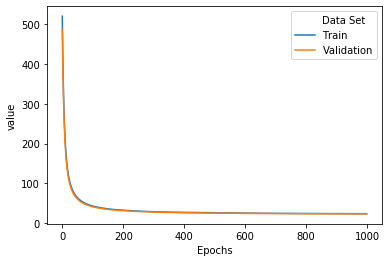

In [14]:
loss_plot = pd.DataFrame(np.transpose([range(epochs), Train_Loss, Val_Loss]), \
                         columns=['Epochs', 'Train', 'Validation']).melt(id_vars='Epochs', var_name='Data Set')
sns.lineplot(x='Epochs', y='value', data=loss_plot, hue='Data Set');

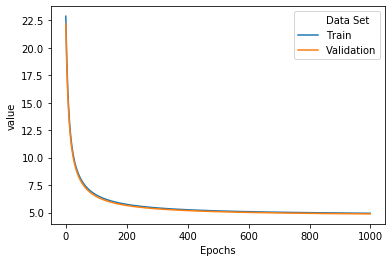

In [15]:
loss_plot = pd.DataFrame(np.transpose([range(epochs), Train_rmse, Val_rmse]), \
                         columns=['Epochs', 'Train', 'Validation']).melt(id_vars='Epochs', var_name='Data Set')
sns.lineplot(x='Epochs', y='value', data=loss_plot, hue='Data Set');